In [43]:
import face_recognition
import os
import glob
import pandas as pd
import numpy as np
import face_recognition

The face_recognition package is a library that enables you to recognize and manipulate faces in images with Python or the command line. It uses dlib’s advanced face recognition model that employs deep learning and achieves an accuracy of 99.38% on the Labeled Faces in the Wild benchmark, a common face recognition dataset. For this project, we used a GitHub Codespace (devcontainer) to compile the [Dlib][dlib] library more easily, as it is more convenient to do it on a Linux system than on Windows.

[dlib]: http://dlib.net/


Here's a simple usage to recognize Obama, and then see if Trump matches with him...


First we import the images and then extract the encondings using the face_recognition library.


In [44]:
obama_image = face_recognition.load_image_file('../images/obama_1.jpg')
obama_two_image = face_recognition.load_image_file("../images/obama_2.jpg")
trump_image = face_recognition.load_image_file("../images/trump.jpg")

In this case we KNOW that theres only one face on each image, so only the first position of the array is important.


In [45]:

#get the encoding for unknown image
obama_encoding = face_recognition.face_encodings(obama_image)[0]
obama_two_encoding = face_recognition.face_encodings(obama_two_image)[0]
trump_encoding = face_recognition.face_encodings(trump_image)[0]

Now let's print the comparision of the encondings extracted from the three images.


In [46]:

#using default tolerance
print("Is Obama better smilling?:",face_recognition.compare_faces([obama_encoding], obama_two_encoding, tolerance=0.6))
print("Does Trump match Obama?",face_recognition.compare_faces([obama_encoding, obama_two_encoding], trump_encoding, tolerance=0.6))

Is Obama better smilling?: [True]
Does Trump match Obama? [False, False]


Now let's do a run using a dataset!

First we download and extract a dataset to a local folder


In [47]:
# Import the requests module to make HTTP requests
import requests
import tarfile

# Choose a face dataset to download
# For example, using the Labeled Faces in the Wild dataset
dataset_url = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
dataset_file = "../dataset/lfw.tgz"

# Make a GET request to the dataset URL and save the content to a file
response = requests.get(dataset_url)
with open(dataset_file, "wb") as f:
  f.write(response.content)

# Extract the tgz file contents into a folder
with tarfile.open(dataset_file, "r") as tf:
    tf.extractall(path="../")

In [48]:

#for each folder in the lfw load the encondings of the images

# Get a list of all folders with more than 20 image
image_folders = [f for f in glob.glob("../lfw/*") if len(os.listdir(f)) > 20]

# Initialize an empty dataframe two columns (name, encoding)
facesDf = pd.DataFrame(columns=["name", "path", "encoding"])
# add each image path and name to the dataframe
arr = np.array([])

#this loop takes a while to run(~7min)
for image_folder in image_folders:
    # Get the celebrity name from the folder name
    celebrity_name = os.path.basename(image_folder).replace("_", " ")
    #for each image in the folder get the encondings
    for filename in glob.glob(os.path.join(image_folder, "*.jpg")):
        # Load the image
        image = face_recognition.load_image_file(filename) 
        encondings = face_recognition.face_encodings(image)
        facesDf = pd.concat([facesDf, pd.DataFrame([[celebrity_name, filename, encondings]], columns=["name", "path", "encoding"])])

#adjust the encoding column to be an array of arrays
print("Done loading images")

Done loading images


Let's save the dataframe into a JSON file for future reference


In [49]:
# fix index of the dataframe
facesDf = facesDf.reset_index(drop=True)

#save the dataframe to a json file
facesDf.to_json("../dataset/lfw.json")


If needed, the snipet to load the CSV


In [50]:
#load the JSON data
faces = pd.read_json("../dataset/lfw.json")
#convert the encoding column to a numpy array of array of numbers
faces['encoding'] = faces['encoding'].apply(lambda x: [[float(z) for z in i] for i in x])
print(faces.head(2))

           name                                       path   
0  Andre Agassi  ../lfw/Andre_Agassi/Andre_Agassi_0020.jpg  \
1  Andre Agassi  ../lfw/Andre_Agassi/Andre_Agassi_0004.jpg   

                                            encoding  
0  [[-0.0984027311, 0.1153762192, 0.0804727226, -...  
1  [[-0.0275862142, 0.0864372998, 0.004418062, -0...  


Sets

Separate the encondings in two sets one for reference and one for testing


In [51]:
from sklearn.model_selection import train_test_split

ref, test = train_test_split(faces, test_size=0.3, random_state=42)
print("Reference set size: {}, Test set size: {}".format(len(ref), len(test)))



Reference set size: 2046, Test set size: 877


Below we have a graph showing the class(by name) distribution in the reference and test set


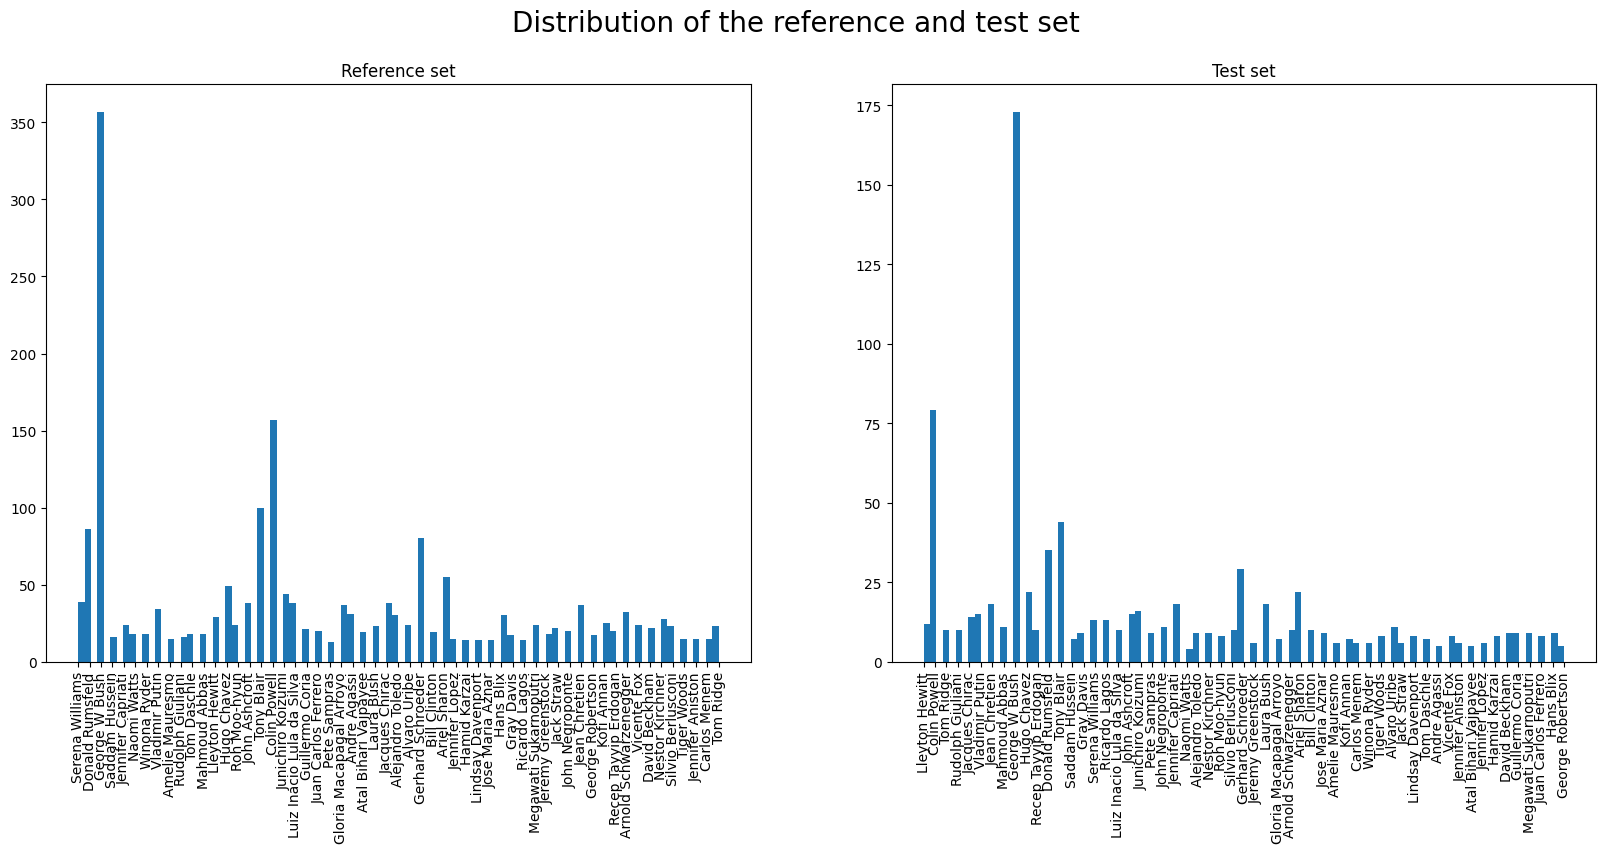

In [52]:

#plot the distribution of the reference and test set
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 7.5))
plt.suptitle("Distribution of the reference and test set", fontsize=20)
plt.subplot(1, 2, 1)
plt.title("Reference set")
plt.hist(ref['name'], bins=100)
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
plt.title("Test set")
plt.hist(test['name'], bins=100)
plt.xticks(rotation=90)
plt.show()

The class distribution overlap in this test case was:


In [53]:
ref_names = set(ref['name'])
test_names = set(test['name'])
common_names = list(ref_names.intersection(test_names))
print("Total number of names: {}".format(len(ref_names.union(test_names))))
print("Number of common names: {}".format(len(common_names)))

test_exclusive_names = list(test_names - ref_names)
ref_exclusive_names = list(ref_names - test_names)
if(len(test_exclusive_names) > 0):
    print("Test set exclusive names: {}".format(test_exclusive_names))
if(len(ref_exclusive_names) > 0):
    print("Reference set exclusive names: {}".format(ref_exclusive_names))

Total number of names: 57
Number of common names: 57


For each test item we need to verify that it only matches with the correct reference. In this case we are using a tolerance of 0.3(lower has a more strict comparison)


In [55]:
ref_encodings = ref["encoding"]

#convert ref_encodings to a list of lists
r = 0
w = 0
# discarding unnecessary columns

matches = pd.DataFrame(columns=["name", "result"])

for _, row in test.iterrows():
    # check if the each encoding in the test item matches with the reference encodings
    test_row = np.array(row["encoding"])
    for test_item in test_row:
        #compare the face encodings and check if they match
        s = r
        k = w
        for _,ref_item in ref.iterrows():
            ref_enc = np.array(ref_item["encoding"])
            localMatches = face_recognition.compare_faces(ref_enc, test_item, tolerance=0.3)
            if True in localMatches:
                #check if the match is in the same name
                if ref_item["name"] == row["name"]:
                    r +=1
                else:
                    w +=1
        #if no match was found increase the wrong counter when the reference set has an item with the same name
        if s == r & k == w:
            #check if the reference set has an item with the same name
            if row["name"] in ref["name"]:
                w +=1

In [57]:
print("Right: {}".format(r))
print("Wrong: {}".format(w))
print("Accuracy: {}".format(r/(r+w)))


Right: 1520
Wrong: 24
Accuracy: 0.9844559585492227
